In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
from tqdm.auto import tqdm

from timeit import default_timer as timer

import torchmetrics
from torchmetrics.classification import MulticlassConfusionMatrix
device = 'cuda' if torch.cuda.is_available() else 'cpu'
metric = torchmetrics.classification.Accuracy(task="multiclass", num_classes=10)
metric.to(device)

MulticlassAccuracy()

In [2]:
train_data = datasets.FashionMNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None,
)

test_data = datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor(), 
    target_transform=None,
)

In [3]:
len(train_data), len(test_data)

(60000, 10000)

In [4]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

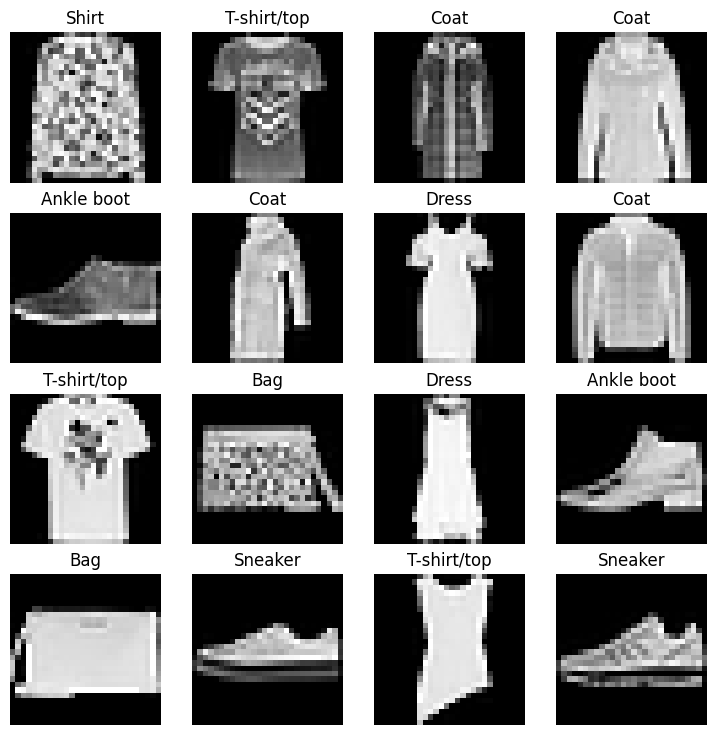

In [5]:
fig, ax = plt.subplots(4, 4, figsize=(9, 9))
ax = ax.flatten()

for i in range(16):
    idx = torch.randint(0, len(train_data), [1]).item()
    img, label = train_data[idx]
    ax[i].imshow(img.squeeze(), cmap='gray')
    ax[i].set_title(class_names[label])
    ax[i].axis(False)

In [6]:
train_data, test_data

(Dataset FashionMNIST
     Number of datapoints: 60000
     Root location: data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset FashionMNIST
     Number of datapoints: 10000
     Root location: data
     Split: Test
     StandardTransform
 Transform: ToTensor())

In [7]:
BATCH_SIZE = 32
train_dataloader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False)

len(train_dataloader), len(test_dataloader), len(train_dataloader.dataset), len(test_dataloader.dataset)

(1875, 313, 60000, 10000)

In [8]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [9]:
class FashionMNISTModelV0(nn.Module):
    def __init__(self, input_shape: int, output_shape: int):
        super().__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=32, out_features=10),
        )
        
    def forward(self, x):
        x = self.conv_block(x)
        x = self.classifier(x)
        return x

In [10]:
model_0 = FashionMNISTModelV0(input_shape=1, output_shape=len(class_names)).to(device)

In [11]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [12]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn):

    train_loss, train_acc = 0, 0
    model.train()

    for batch, (X, y) in enumerate(tqdm(train_dataloader)):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += metric(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc * 100:.4f}%')

In [13]:
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              optimizer: torch.optim.Optimizer,
              accuracy_fn):

    test_loss, test_acc = 0, 0
    
    model.eval()
    
    with torch.inference_mode():
        for X, y in tqdm(data_loader):
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            test_loss += loss_fn(y_pred, y)
            test_acc += metric(y_pred, y)

        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc * 100:.4f}%\n')

In [14]:
epochs = 30

start_time = timer()

for epoch in tqdm(range(epochs)):
    print(f'\nEpoch: {epoch}\n----------')
    train_step(model_0, train_dataloader, loss_fn, optimizer, metric)
    test_step(model_0, test_dataloader, loss_fn, optimizer, metric)

end_time = timer()

print(f'Time: {end_time - start_time:.4f}')

  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 0
----------


  0%|          | 0/1875 [00:00<?, ?it/s]

Train Loss: 1.5575, Train Accuracy: 40.2733%


  0%|          | 0/313 [00:00<?, ?it/s]

Test Loss: 0.5400, Test Accuracy: 79.8223%


Epoch: 1
----------


  0%|          | 0/1875 [00:00<?, ?it/s]

Train Loss: 0.4241, Train Accuracy: 84.2950%


  0%|          | 0/313 [00:00<?, ?it/s]

Test Loss: 0.3980, Test Accuracy: 84.9641%


Epoch: 2
----------


  0%|          | 0/1875 [00:00<?, ?it/s]

Train Loss: 0.3282, Train Accuracy: 87.7050%


  0%|          | 0/313 [00:00<?, ?it/s]

Test Loss: 0.3546, Test Accuracy: 86.5415%


Epoch: 3
----------


  0%|          | 0/1875 [00:00<?, ?it/s]

Train Loss: 0.2829, Train Accuracy: 89.4267%


  0%|          | 0/313 [00:00<?, ?it/s]

Test Loss: 0.2866, Test Accuracy: 89.7364%


Epoch: 4
----------


  0%|          | 0/1875 [00:00<?, ?it/s]

Train Loss: 0.2523, Train Accuracy: 90.7433%


  0%|          | 0/313 [00:00<?, ?it/s]

Test Loss: 0.2989, Test Accuracy: 89.1074%


Epoch: 5
----------


  0%|          | 0/1875 [00:00<?, ?it/s]

Train Loss: 0.2320, Train Accuracy: 91.4917%


  0%|          | 0/313 [00:00<?, ?it/s]

Test Loss: 0.2752, Test Accuracy: 89.9461%


Epoch: 6
----------


  0%|          | 0/1875 [00:00<?, ?it/s]

Train Loss: 0.2152, Train Accuracy: 92.0333%


  0%|          | 0/313 [00:00<?, ?it/s]

Test Loss: 0.2544, Test Accuracy: 90.5152%


Epoch: 7
----------


  0%|          | 0/1875 [00:00<?, ?it/s]

Train Loss: 0.2014, Train Accuracy: 92.4717%


  0%|          | 0/313 [00:00<?, ?it/s]

Test Loss: 0.2407, Test Accuracy: 91.3638%


Epoch: 8
----------


  0%|          | 0/1875 [00:00<?, ?it/s]

Train Loss: 0.1895, Train Accuracy: 92.9717%


  0%|          | 0/313 [00:00<?, ?it/s]

Test Loss: 0.2378, Test Accuracy: 91.5935%


Epoch: 9
----------


  0%|          | 0/1875 [00:00<?, ?it/s]

Train Loss: 0.1822, Train Accuracy: 93.1783%


  0%|          | 0/313 [00:00<?, ?it/s]

Test Loss: 0.2388, Test Accuracy: 91.3938%


Epoch: 10
----------


  0%|          | 0/1875 [00:00<?, ?it/s]

Train Loss: 0.1734, Train Accuracy: 93.5583%


  0%|          | 0/313 [00:00<?, ?it/s]

Test Loss: 0.2595, Test Accuracy: 90.7448%


Epoch: 11
----------


  0%|          | 0/1875 [00:00<?, ?it/s]

Train Loss: 0.1622, Train Accuracy: 93.8967%


  0%|          | 0/313 [00:00<?, ?it/s]

Test Loss: 0.2474, Test Accuracy: 91.3139%


Epoch: 12
----------


  0%|          | 0/1875 [00:00<?, ?it/s]

Train Loss: 0.1586, Train Accuracy: 94.0717%


  0%|          | 0/313 [00:00<?, ?it/s]

Test Loss: 0.2254, Test Accuracy: 91.7532%


Epoch: 13
----------


  0%|          | 0/1875 [00:00<?, ?it/s]

Train Loss: 0.1509, Train Accuracy: 94.3850%


  0%|          | 0/313 [00:00<?, ?it/s]

Test Loss: 0.2482, Test Accuracy: 91.2540%


Epoch: 14
----------


  0%|          | 0/1875 [00:00<?, ?it/s]

Train Loss: 0.1472, Train Accuracy: 94.4900%


  0%|          | 0/313 [00:00<?, ?it/s]

Test Loss: 0.2885, Test Accuracy: 91.0044%


Epoch: 15
----------


  0%|          | 0/1875 [00:00<?, ?it/s]

Train Loss: 0.1445, Train Accuracy: 94.6800%


  0%|          | 0/313 [00:00<?, ?it/s]

Test Loss: 0.2581, Test Accuracy: 91.5435%


Epoch: 16
----------


  0%|          | 0/1875 [00:00<?, ?it/s]

Train Loss: 0.1358, Train Accuracy: 95.0200%


  0%|          | 0/313 [00:00<?, ?it/s]

Test Loss: 0.2556, Test Accuracy: 91.8830%


Epoch: 17
----------


  0%|          | 0/1875 [00:00<?, ?it/s]

Train Loss: 0.1344, Train Accuracy: 94.8900%


  0%|          | 0/313 [00:00<?, ?it/s]

Test Loss: 0.2749, Test Accuracy: 91.2041%


Epoch: 18
----------


  0%|          | 0/1875 [00:00<?, ?it/s]

Train Loss: 0.1301, Train Accuracy: 95.1050%


  0%|          | 0/313 [00:00<?, ?it/s]

Test Loss: 0.2769, Test Accuracy: 91.7332%


Epoch: 19
----------


  0%|          | 0/1875 [00:00<?, ?it/s]

Train Loss: 0.1299, Train Accuracy: 95.2450%


  0%|          | 0/313 [00:00<?, ?it/s]

Test Loss: 0.3153, Test Accuracy: 90.7947%


Epoch: 20
----------


  0%|          | 0/1875 [00:00<?, ?it/s]

Train Loss: 0.1263, Train Accuracy: 95.2817%


  0%|          | 0/313 [00:00<?, ?it/s]

Test Loss: 0.2630, Test Accuracy: 91.5335%


Epoch: 21
----------


  0%|          | 0/1875 [00:00<?, ?it/s]

Train Loss: 0.1222, Train Accuracy: 95.3733%


  0%|          | 0/313 [00:00<?, ?it/s]

Test Loss: 0.2777, Test Accuracy: 91.2240%


Epoch: 22
----------


  0%|          | 0/1875 [00:00<?, ?it/s]

Train Loss: 0.1161, Train Accuracy: 95.6567%


  0%|          | 0/313 [00:00<?, ?it/s]

Test Loss: 0.2726, Test Accuracy: 91.3938%


Epoch: 23
----------


  0%|          | 0/1875 [00:00<?, ?it/s]

Train Loss: 0.1172, Train Accuracy: 95.6767%


  0%|          | 0/313 [00:00<?, ?it/s]

Test Loss: 0.2862, Test Accuracy: 91.6933%


Epoch: 24
----------


  0%|          | 0/1875 [00:00<?, ?it/s]

Train Loss: 0.1149, Train Accuracy: 95.7567%


  0%|          | 0/313 [00:00<?, ?it/s]

Test Loss: 0.3046, Test Accuracy: 90.9744%


Epoch: 25
----------


  0%|          | 0/1875 [00:00<?, ?it/s]

Train Loss: 0.1086, Train Accuracy: 95.9600%


  0%|          | 0/313 [00:00<?, ?it/s]

Test Loss: 0.2882, Test Accuracy: 91.8630%


Epoch: 26
----------


  0%|          | 0/1875 [00:00<?, ?it/s]

Train Loss: 0.1122, Train Accuracy: 95.7967%


  0%|          | 0/313 [00:00<?, ?it/s]

Test Loss: 0.2824, Test Accuracy: 91.7432%


Epoch: 27
----------


  0%|          | 0/1875 [00:00<?, ?it/s]

Train Loss: 0.1110, Train Accuracy: 95.8600%


  0%|          | 0/313 [00:00<?, ?it/s]

Test Loss: 0.2967, Test Accuracy: 91.6633%


Epoch: 28
----------


  0%|          | 0/1875 [00:00<?, ?it/s]

Train Loss: 0.1093, Train Accuracy: 96.0383%


  0%|          | 0/313 [00:00<?, ?it/s]

Test Loss: 0.2991, Test Accuracy: 91.1741%


Epoch: 29
----------


  0%|          | 0/1875 [00:00<?, ?it/s]

Train Loss: 0.1079, Train Accuracy: 96.0667%


  0%|          | 0/313 [00:00<?, ?it/s]

Test Loss: 0.3224, Test Accuracy: 90.8746%

Time: 818.0503


In [15]:
def draw_confusion_matrix(confusion_matrix):
    confusion_matrix_tensor = confusion_matrix.compute()
    plt.figure(figsize=(8, 6))
    plt.imshow(confusion_matrix_tensor.cpu().numpy(), cmap='Blues')
    plt.title('Confusion Matrix')
    plt.colorbar()
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.xticks(range(10))
    plt.yticks(range(10))
    cm = confusion_matrix_tensor.cpu().numpy()
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.show()

  0%|          | 0/313 [00:00<?, ?it/s]

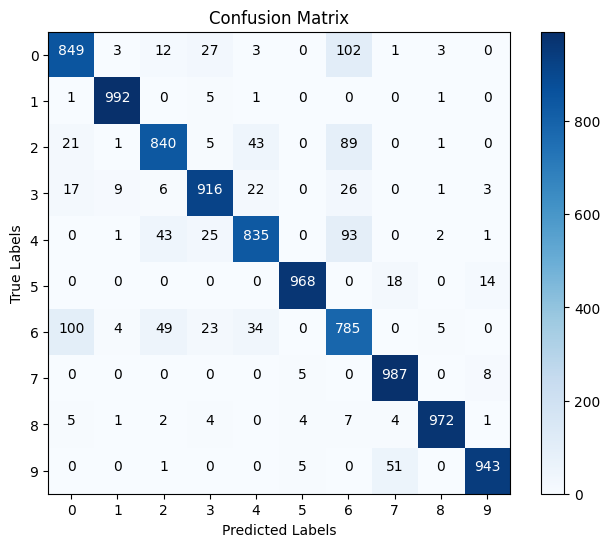

{'model_name:': 'FashionMNISTModelV0',
 'model_loss': 0.3223775029182434,
 'model_accuracy': 0.9087460041046143}

In [16]:
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn):
    loss, acc = 0, 0
    confusion_matrix = MulticlassConfusionMatrix(num_classes=10).to(device)
    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(data_loader):
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss += loss_fn(y_pred, y)
            acc += metric(y_pred, y)
            confusion_matrix.update(y_pred.argmax(dim=1), y)
            
        loss /= len(data_loader)
        acc /= len(data_loader)
    
    draw_confusion_matrix(confusion_matrix)
    return {'model_name:': model.__class__.__name__,
            'model_loss': loss.item(),
            'model_accuracy': acc.item()}
    
eval_model(model_0, test_dataloader, loss_fn, metric)